In [116]:
import pandas as pd
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

In [105]:
regions = pd.read_csv('./temperature and precipitation/climate_region.csv')

In [106]:
regions.head()

,Name,MapDate,DSCI
0,High Plains,20011218,104
1,High Plains,20011225,105
2,High Plains,20020101,108
3,High Plains,20020108,121
4,High Plains,20020115,124


In [107]:
#regions = pd.get_dummies(regions, columns=['Name'])


In [108]:
regions.head()

,Name,MapDate,DSCI
0,High Plains,20011218,104
1,High Plains,20011225,105
2,High Plains,20020101,108
3,High Plains,20020108,121
4,High Plains,20020115,124


In [109]:
mean_dsci = regions.groupby('Name', as_index=False)['DSCI'].mean()

mean_dsci


,Name,DSCI
0,High Plains,119.887931
1,Midwest,46.305556
2,Northeast,29.101533
3,South,98.890805
4,Southeast,72.484674
5,West,104.840038


In [110]:
high_plains = regions[regions['Name'] == 'High Plains']

In [111]:
high_plains['MapDate'] = pd.to_datetime(high_plains['MapDate'], format = '%Y%m%d')

<ipython-input-111-f55afb0e8f52>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_plains['MapDate'] = pd.to_datetime(high_plains['MapDate'], format = '%Y%m%d')


In [112]:
high_plains.head()

,Name,MapDate,DSCI
0,High Plains,2001-12-18,104
1,High Plains,2001-12-25,105
2,High Plains,2002-01-01,108
3,High Plains,2002-01-08,121
4,High Plains,2002-01-15,124


In [113]:
high_plains.drop([0, 1], inplace = True)

/Users/sonnguyen/opt/anaconda3/envs/dsi-111/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [114]:
high_plains_dsci = high_plains.groupby(high_plains['MapDate'].dt.year)['DSCI'].mean()


Text(0.5, 1.0, 'Average DSCI in High Plains by Year')

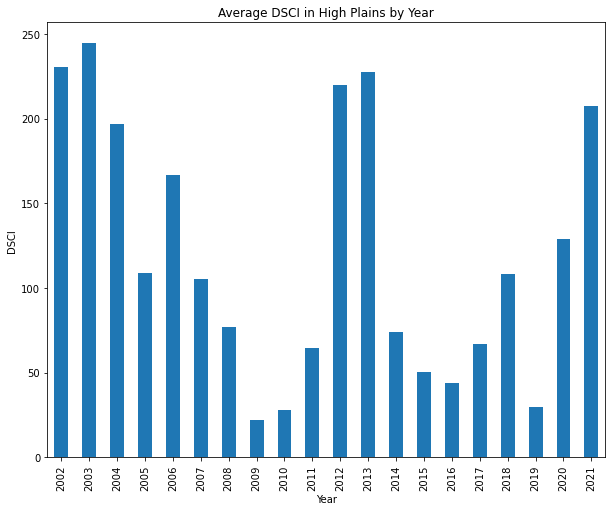

In [133]:
high_plains_dsci.plot(kind = 'bar', figsize = (10, 8))
plt.xlabel("Year")
plt.ylabel("DSCI")
plt.title('Average DSCI in High Plains by Year')

In [136]:
high_plains.index = high_plains['MapDate']

Text(0.5, 1.0, 'High Plains Drought Severity since 2002')

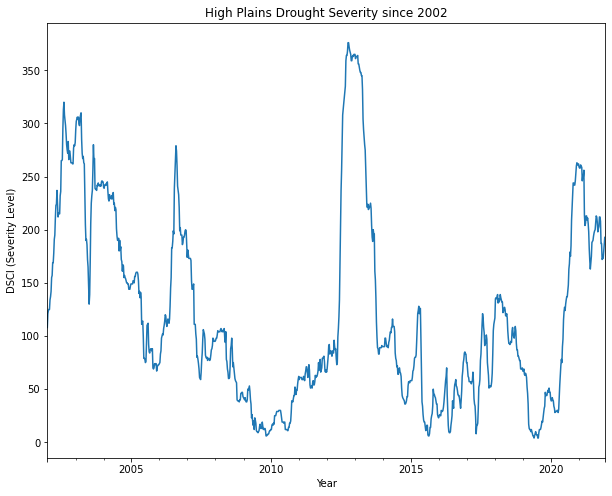

In [144]:
high_plains['DSCI'].plot(figsize = (10, 8))
plt.xlabel("Year")
plt.ylabel("DSCI (Severity Level)")
plt.title('High Plains Drought Severity since 2002')

In [145]:
def df_to_X_y(df, windowsize=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-windowsize):
        row = [[a] for a in df_as_np[i:i+5]]
        X.append(row)
        label = df_as_np[i+5]
        y.append(label)
    return np.array(X), np.array(y)

In [210]:
WINDOW_SIZE = 5
X, y = df_to_X_y(high_plains['DSCI'], WINDOW_SIZE)
X.shape, y.shape

((1037, 5, 1), (1037,))

In [211]:
X_train, y_train = X[:700], y[:700]
X_val, y_val = X[700:800], y[700:800]
X_test, y_test = X[800:], y[800:]

In [212]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5,1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [244]:
cp = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer = Adam(learning_rate=0.005), metrics=[RootMeanSquaredError()])

In [245]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp])

Epoch 1/10
22/22 [==============================] - 6s 34ms/step - loss: 492.5301 - root_mean_squared_error: 22.1930 - val_loss: 41.8825 - val_root_mean_squared_error: 6.4717


INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


Epoch 2/10
22/22 [==============================] - 0s 7ms/step - loss: 209.4674 - root_mean_squared_error: 14.4730 - val_loss: 41.9696 - val_root_mean_squared_error: 6.4784
Epoch 3/10
22/22 [==============================] - 0s 10ms/step - loss: 142.3682 - root_mean_squared_error: 11.9318 - val_loss: 67.0260 - val_root_mean_squared_error: 8.1869
Epoch 4/10
22/22 [==============================] - 0s 15ms/step - loss: 121.8279 - root_mean_squared_error: 11.0376 - val_loss: 42.1008 - val_root_mean_squared_error: 6.4885
Epoch 5/10
22/22 [==============================] - 0s 13ms/step - loss: 92.6449 - root_mean_squared_error: 9.6252 - val_loss: 49.4560 - val_root_mean_squared_error: 7.0325
Epoch 6/10
22/22 [==============================] - 0s 12ms/step - loss: 92.2120 - root_mean_squared_error: 9.6027 - val_loss: 46.0534 - val_root_mean_squared_error: 6.7863
Epoch 7/10
22/22 [==============================] - 0s 12ms/step - loss: 85.1697 - root_mean_squared_error: 9.2287 - val_loss: 45.

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


In [246]:
from tensorflow.keras.models import load_model
model1 = load_model("model1/")

In [247]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals': y_train})
train_results

,Train Predictions,Actuals
0,123.993820,134
1,139.482834,137
2,138.304703,142
3,144.391144,155
4,160.127518,157
...,...,...
695,32.260628,34
696,33.167774,26
697,23.459351,21
698,19.247177,19


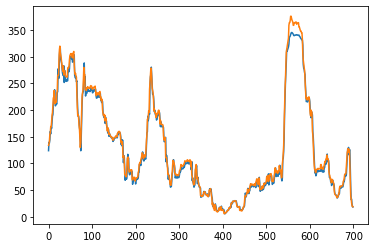

In [248]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'])

In [249]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals': y_val})
val_results

,Val Predictions,Actuals
0,18.931042,15
1,15.639430,11
2,12.569127,12
3,12.983653,16
4,17.122114,16
...,...,...
95,21.318619,8
96,10.537806,15
97,15.304797,16
98,17.531191,18


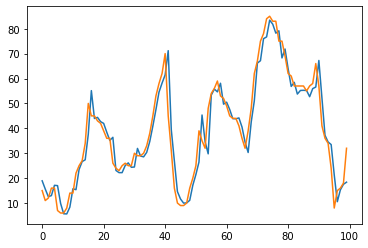

In [250]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

In [251]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':val_predictions, 'Actuals': y_val})
test_results

,Test Predictions,Actuals
0,18.931042,15
1,15.639430,11
2,12.569127,12
3,12.983653,16
4,17.122114,16
...,...,...
95,21.318619,8
96,10.537806,15
97,15.304797,16
98,17.531191,18


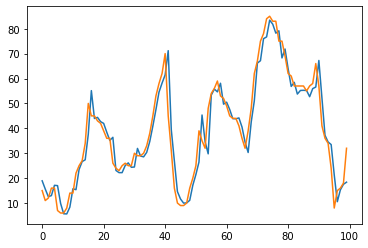

In [252]:
plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actuals'])